In [2]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Intro to QAOA
=============

::: {.meta}
:property=\"og:description\": Learn how to implement QAOA with PennyLane
:property=\"og:image\":
<https://pennylane.ai/qml/_images/qaoa_layer.png>
:::

::: {.related}
tutorial\_qaoa\_maxcut QAOA for MaxCut
:::

*Author: Jack Ceroni --- Posted: 18 November 2020. Last updated: 11
January 2021.*

The Quantum Approximate Optimization Algorithm (QAOA) is a
widely-studied method for solving combinatorial optimization problems on
NISQ devices. The applications of QAOA are broad and far-reaching, and
the performance of the algorithm is of great interest to the quantum
computing research community.

![](../demonstrations/qaoa_module/qaoa_circuit.png){.align-center
width="90.0%"}

The goal of this tutorial is to introduce the basic concepts of QAOA and
to guide you through PennyLane\'s built-in QAOA functionality. You will
learn how to use time evolution to establish a connection between
Hamiltonians and quantum circuits, and how to layer these circuits to
create more powerful algorithms. These simple ingredients, together with
the ability to optimize quantum circuits, are the building blocks of
QAOA. By focusing on the fundamentals, PennyLane provides general and
flexible capabilities that can be tailored and refined to implement QAOA
for a wide variety of problems. In the last part of the tutorial, you
will learn how to bring these pieces together and deploy a complete QAOA
workflow to solve the minimum vertex cover problem. Let\'s get started!
🎉

Circuits and Hamiltonians
-------------------------

When considering quantum circuits, it is often convenient to define them
by a series of quantum gates. But there are many instances where it is
useful to think of a quantum circuit in terms of a
[Hamiltonian](https://en.wikipedia.org/wiki/Hamiltonian_(quantum_mechanics)).
Indeed, gates are physically implemented by performing time evolution
under a carefully engineered Hamiltonian. These transformations are
described by the time evolution operator, which is a unitary defined as:


$$U(H, \ t) \ = \ e^{-i H t / \hbar}.$$

The time evolution operator is determined completely in terms of a
Hamiltonian $H$ and a scalar $t$ representing time. In fact, any unitary
$U$ can be written in the form $e^{i \gamma H}$, where $\gamma$ is a
scalar and $H$ is a Hermitian operator, interpreted as a Hamiltonian.
Thus, time evolution establishes a connection that allows us to describe
quantum circuits in terms of Hamiltonians. 🤯

In general, implementing a quantum circuit that exactly exponentiates a
Hamiltonian with many non-commuting terms, i.e., a Hamiltonian of the
form:

$$H \ = \ H_1 \ + \ H_2 \ + \ H_3 \ + \ \cdots \ + \ H_N,$$

is very challenging. Instead, we can use the
[Trotter-Suzuki](https://en.wikipedia.org/wiki/Lie_product_formula)
decomposition formula

$$e^{A \ + \ B} \ \approx \ \Big(e^{A/n} e^{B/n}\Big)^{n},$$

to implement an *approximate* time-evolution unitary:

$$U(H, t, n) \ = \ \displaystyle\prod_{j \ = \ 1}^{n}
\displaystyle\prod_{k} e^{-i H_k t / n} \ \ \ \ \ \ \ \ \ \ H \
= \ \displaystyle\sum_{k} H_k,$$

where $U$ approaches $e^{-i H t}$ as $n$ becomes larger.

![](../demonstrations/qaoa_module/ham_circuit.png){.align-center
width="70.0%"}

In PennyLane, this is implemented using the
`~.pennylane.templates.ApproxTimeEvolution`{.interpreted-text
role="func"} template. For example, let\'s say we have the following
Hamiltonian:


In [7]:
import pennylane as qml

H = qml.Hamiltonian(
    [1, 1, 0.5],
    [qml.PauliX(0), qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)]
)
print(H)

  (1) [X0]
+ (1) [Z1]
+ (0.5) [X0 X1]


We can implement the approximate time-evolution operator corresponding
to this Hamiltonian:


In [4]:
dev = qml.device('default.qubit', wires=2)

t = 1
n = 2

@qml.qnode(dev)
def circuit():
    qml.ApproxTimeEvolution(H, t, n)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit, expansion_strategy='device')())

0: ──RX(1.00)─╭RXX(0.50)──RX(1.00)─╭RXX(0.50)─┤  <Z>
1: ──RZ(1.00)─╰RXX(0.50)──RZ(1.00)─╰RXX(0.50)─┤  <Z>


Layering circuits
=================

Think of all the times you have copied a text or image, then pasted it
repeatedly to create many duplicates. This is also a useful feature when
designing quantum algorithms! The idea of repetition is ubiquitous in
quantum computing: from amplitude amplification in [Grover's
algorithm](https://en.wikipedia.org/wiki/Grover%27s_algorithm) to layers
in [quantum neural
networks](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.1.033063)
and [Hamiltonian
simulation](https://en.wikipedia.org/wiki/Hamiltonian_simulation),
repeated application of a circuit is a central tool in quantum
algorithms.

![](../demonstrations/qaoa_module/repeat.png){.align-center
width="100.0%"}

Circuit repetition is implemented in PennyLane using the
`~.pennylane.layer`{.interpreted-text role="func"} function. This method
allows us to take a function containing either quantum operations, a
template, or even a single quantum gate, and repeatedly apply it to a
set of wires.

![](../demonstrations/qaoa_module/qml_layer.png){.align-center
width="90.0%"}

To create a larger circuit consisting of many repetitions, we pass the
circuit to be repeated as an argument and specify the number of
repetitions. For example, let\'s say that we want to layer the following
circuit three times:


In [5]:
def circ(theta):
    qml.RX(theta, wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev)
def circuit(param):
    circ(param)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit)(0.5))

0: ──RX(0.50)─╭●─┤  <Z>
1: ──H────────╰X─┤  <Z>


We simply pass this function into the
`~.pennylane.layer`{.interpreted-text role="func"} function:


In [6]:
@qml.qnode(dev)
def circuit(params, **kwargs):
    qml.layer(circ, 3, params)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit)([0.3, 0.4, 0.5]))

0: ──RX(0.30)─╭●──RX(0.40)─╭●──RX(0.50)─╭●─┤  <Z>
1: ──H────────╰X──H────────╰X──H────────╰X─┤  <Z>


We have learned how time evolution can be used to create circuits from
Hamiltonians, and how these can be layered to create longer circuits. We
are now ready to explore QAOA.


QAOA
====

The quantum approximate optimization algorithm (QAOA) is a general
technique that can be used to find approximate solutions to
combinatorial optimization problems, in particular problems that can be
cast as searching for an optimal bitstring. QAOA consists of the
following steps:

1.  Define a *cost Hamiltonian* $H_C$ such that its ground state encodes
    the solution to the optimization problem.

2.  Define a *mixer Hamiltonian* $H_M$.

3.  Construct the circuits $e^{-i \gamma H_C}$ and $e^{-i\alpha H_M}$.
    We call these the *cost* and *mixer layers*, respectively.

4.  Choose a parameter $n\geq 1$ and build the circuit

    $$U(\boldsymbol\gamma, \ \boldsymbol\alpha) \ = \ e^{-i \alpha_n H_M}
    e^{-i \gamma_n H_C} \ ... \ e^{-i \alpha_1 H_M} e^{-i \gamma_1 H_C},$$

    consisting of repeated application of the cost and mixer layers.

5.  Prepare an initial state, apply
    $U(\boldsymbol\gamma,\boldsymbol\alpha)$, and use classical
    techniques to optimize the parameters.

6.  After the circuit has been optimized, measurements of the output
    state reveal approximate solutions to the optimization problem.

In summary, the starting point of QAOA is the specification of cost and
mixer Hamiltonians. We then use time evolution and layering to create a
variational circuit and optimize its parameters. The algorithm concludes
by sampling from the circuit to get an approximate solution to the
optimization problem. Let\'s see it in action! 🚀


Minimum Vertex Cover with QAOA
==============================

Our goal is to find the [minimum vertex
cover](https://en.wikipedia.org/wiki/Vertex_cover) of a graph: a
collection of vertices such that each edge in the graph contains at
least one of the vertices in the cover. Hence, these vertices \"cover\"
all the edges 👍. We wish to find the vertex cover that has the smallest
possible number of vertices.

Vertex covers can be represented by a bit string where each bit denotes
whether the corresponding vertex is present in the cover. For example,
the bit string 01010 represents a cover consisting of the second and
fourth vertex in a graph with five vertices.

![](../demonstrations/qaoa_module/minvc.png){.align-center
width="90.0%"}

To implement QAOA with PennyLane, we first import the necessary
dependencies:


In [1]:
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

We also define the four-vertex graph for which we want to find the
minimum vertex cover:


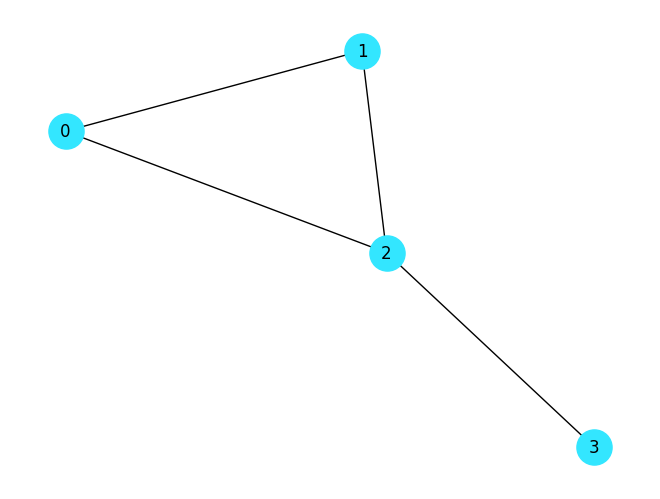

In [2]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True, node_size=640, node_color=(0.2, .9, 1))

There are two minimum vertex covers of this graph: the vertices 0 and 2,
and the vertices 1 and 2. These can be respectively represented by the
bit strings 1010 and 0110. The goal of the algorithm is to sample these
bit strings with high probability.

The PennyLane QAOA module has a collection of built-in optimization
problems, including minimum vertex cover. For each problem, you can
retrieve the cost Hamiltonian as well as a recommended mixer
Hamiltonian. This makes it straightforward to obtain the Hamiltonians
for specific problems while still permitting the flexibility to make
other choices, for example by adding constraints or experimenting with
different mixers.

In our case, the cost Hamiltonian has two ground states, $|1010\rangle$
and $|0110\rangle$, coinciding with the solutions of the problem. The
mixer Hamiltonian is the simple, non-commuting sum of Pauli-X operations
on each node of the graph:


In [3]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian   (-0.25) [Z3]
+ (0.5) [Z0]
+ (0.5) [Z1]
+ (1.25) [Z2]
+ (0.75) [Z0 Z1]
+ (0.75) [Z0 Z2]
+ (0.75) [Z1 Z2]
+ (0.75) [Z2 Z3]
Mixer Hamiltonian   (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]


A single layer of QAOA consists of time evolution under these
Hamiltonians:

![](../demonstrations/qaoa_module/layer.png){.align-center
width="90.0%"}

While it is possible to use
`~.pennylane.templates.ApproxTimeEvolution`{.interpreted-text
role="func"}, the QAOA module allows you to build the cost and mixer
layers directly using the functions
`~.pennylane.qaoa.cost_layer`{.interpreted-text role="func"} and
`~.pennylane.qaoa.mixer_layer`{.interpreted-text role="func"}, which
take as input the respective Hamiltonian and variational parameters:


In [4]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

We are now ready to build the full variational circuit. The number of
wires is equal to the number of vertices of the graph. We initialize the
state to an even superposition over all basis states. For this example,
we employ a circuit consisting of two QAOA layers:


In [11]:
wires = range(4)
depth = 1

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

Note that `~.pennylane.layer`{.interpreted-text role="func"} allows us
to pass variational parameters `params[0]` and `params[1]` into each
layer of the circuit. That\'s it! The last step is PennyLane\'s
specialty: optimizing the circuit parameters.

The cost function is the expectation value of $H_C$, which we want to
minimize. We use the function `~.pennylane.expval`{.interpreted-text
role="func"} which returns the expectation value of the Hamiltonian with
respect to the circuit\'s output state. We also define the device on
which the simulation is performed. We use the PennyLane-Qulacs plugin to
run the circuit on the Qulacs simulator:


In [12]:
dev = qml.device("qulacs.simulator", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

Finally, we optimize the cost function using the built-in
`~.pennylane.GradientDescentOptimizer`{.interpreted-text role="func"}.
We perform optimization for seventy steps and initialize the parameters:


In [15]:
optimizer = qml.GradientDescentOptimizer()
steps = 70
params = np.array([[0.5], [0.5]], requires_grad=True)

Notice that we set each of the initial parameters to $0.5$. For
demonstration purposes, we chose initial parameters that we know work
fairly well, and don\'t get stuck in any local minima.

The choice of initial parameters for a variational circuit is usually a
difficult problem, so we won\'t linger on it too much in this tutorial,
but it is important to note that finding an initial set of parameters
that work well for a few toy problems often yields good results for more
complex instances of the algorithm as well.

Now, we can optimize the circuit:


In [16]:
for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

Optimal Parameters
[[1.16990142]
 [0.7198162 ]]


In [19]:
cost_function(params)

0.2710090609147977

With the optimal parameters, we can now reconstruct the probability
landscape. We redefine the full QAOA circuit with the optimal
parameters, but this time we return the probabilities of measuring each
bitstring:


In [17]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

Finally, we can display a bar graph showing the probability of measuring
each bitstring:


/tmp/ipykernel_55665/847613202.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


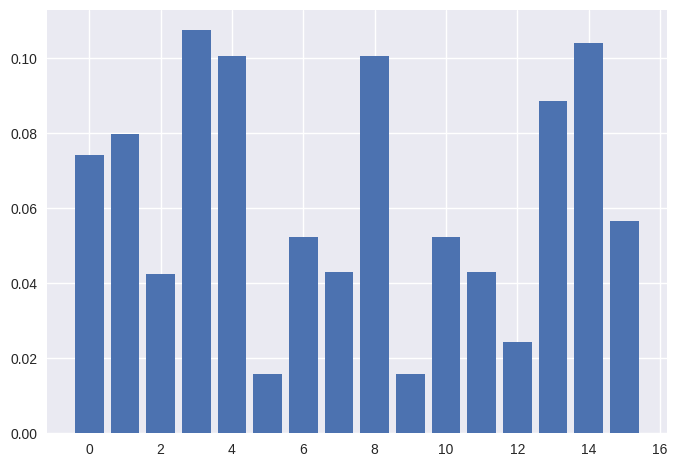

In [18]:
plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.show()

The states $|6\rangle \ = \ |0110\rangle$ and
$|10\rangle \ = \ |1010\rangle$ have the highest probabilities of being
measured, just as expected!

![](../demonstrations/qaoa_module/graph.png){.align-center
width="90.0%"}


Customizing QAOA
================

QAOA is not one-size-fits-all when it comes to solving optimization
problems. In many cases, cost and mixer Hamiltonians will be very
specific to one scenario, and not necessarily fit within the structure
of the pre-defined problems in the `~.pennylane.qaoa`{.interpreted-text
role="func"} submodule. Luckily, one of the core principles behind the
entire PennyLane library is customizability, and this principle hold
true for QAOA submodule as well!

The QAOA workflow above gave us two optimal solutions:
$|6\rangle = |0110\rangle$ and $|10\rangle = |1010\rangle$. What if we
add a constraint that made one of these solutions \"better\" than the
other? Let\'s imagine that we are interested in solutions that minimize
the original cost function, *but also colour the first and third
vertices* $1$. A constraint of this form will favour $|10\rangle$,
making it the only true ground state.

It is easy to introduce constraints of this form in PennyLane. We can
use the `~.pennylane.qaoa.edge_driver`{.interpreted-text role="func"}
cost Hamiltonian to \"reward\" cases in which the first and last
vertices of the graph are $0$:


In [17]:
reward_h = qaoa.edge_driver(nx.Graph([(0, 2)]), ['11'])

We then weigh and add the constraining term to the original minimum
vertex cover Hamiltonian:


In [18]:
new_cost_h = cost_h + 2 * reward_h

Notice that PennyLane allows for simple addition and multiplication of
Hamiltonian objects using inline arithmetic operations ➕ ➖ ✖️➗! Finally,
we can use this new cost Hamiltonian to define a new QAOA workflow:


In [19]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, new_cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(new_cost_h)

params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

Optimal Parameters
[[0.45959941 0.96095271]
 [0.27029962 0.78042396]]


We then reconstruct the probability landscape with the optimal
parameters:


/tmp/ipykernel_7836/1734049057.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


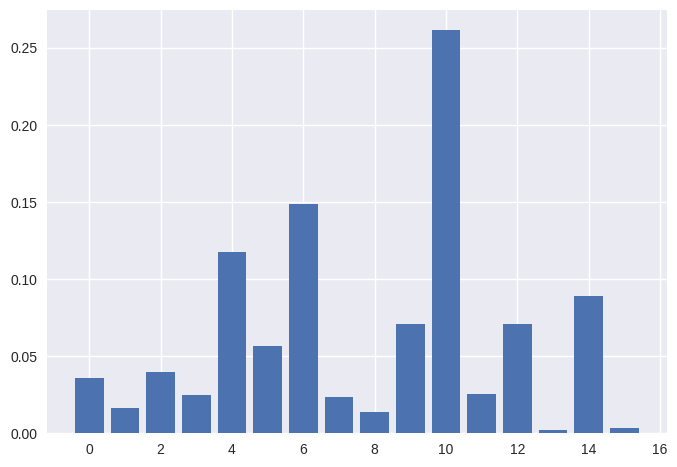

In [20]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(params[0], params[1])

plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.show()

Just as we expected, the $|10\rangle$ state is now favoured over
$|6\rangle$!


Conclusion
==========

You have learned how to use the PennyLane QAOA functionality, while also
surveying some of the fundamental features that make the QAOA module
simple and flexible. Now, it\'s your turn to experiment with QAOA! If
you need some inspiration for how to get started:

-   Experiment with different optimizers and different devices. Which
    ones work the best?
-   Play around with some of the other built-in cost and mixer
    Hamiltonians.
-   Try making your own custom constraining terms. Is QAOA properly
    amplifying some bitstrings over others?

![](../demonstrations/qaoa_module/qaoa_circuit.png){.align-center
width="90.0%"}

About the author
================
